# Analysis of time performance of the soundness verification algorithm for Data Petri Nets

During the generation of DPNs, the following parameters have been taken as an input:

- Places - number of places in the DPN.
- Transitions - number of transitions in the DPN.
- Arcs - number of arcs in the DPN (but actually number of arcs was predetermined by a number of transitions and places but it was possible to configure a number of additional arcs that are added when the backbone of the DPN is constructed)
- Variables - number of variables.
- Conditions - number of atomic conditions in the DPN. Each transition may have 0, 1 or n conditions. In case of n conditions, they can be combined through conjunction and disjunction (logical connective is chosen randomly, but the result expression must conform to DNF).

During the verification LTS for the source DPN is constructed. The LTS has the following properties:
- LtsStates - number of states in the LTS for the DPN.
- LtsArcs - number of arcs in the LTS for the DPN.
- LtsTime - time spent on the LTS construction.

On the LTS, we check boundedness of a DPN and obtain the following property:
- Boundedness - DPN boundedness.

If a DPN is bounded, we proceed to DPN refinement, adding tau-transitions and constructing LTS for the resulting DPN.
At the last step of the verification, LTS for the tau-refined DPN is constructed. We call here this DPN as a 'refined constraint graph'. It has the following properties:
- CgRefStates - number of states in the refined constraint graph for the DPN.
- CgRefArcs - number of arcs in the refined constraint graph for the DPN.
- CgRefTime - time spent on the refined constraint graph construction.


This structure is analyzed and the following properties are obtained:
- DeadTransitions - number of dead transitions in the DPN.
- Deadlocks - existence of deadlocks in the DPN.
- Soundness - whether the DPN data-aware sound or not.

Finally, the program measures the whole time needed for checking a DPN for soundness:

- VerificationTime - number of milliseconds needed for the algorithm to terminate with an answer regarding data-aware soundness of the DPN.

In [1]:
import math
import statistics

import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy import stats
from scipy.stats import norm

import statsmodels.api as sm

### Read dataset for generated DPNs and results of their verification

In [9]:
df = pd.read_csv('Growth//OptimizedVersion.csv')#results_qeIml_total.csv

In [10]:
df

,SatisfiesConds,Places,Transitions,Arcs,Variables,Conditions,Boundedness,LtsStates,LtsArcs,CgRefStates,CgRefArcs,DeadTransitions,Deadlocks,Soundness,VerificationTime,LtsTime,CgRefTime,Id
0,True,7,6,12,7,5,True,5,4,0,0,2,True,False,75,75,0,b7818824-b645-4053-a986-955d9629938b
1,True,15,16,54,8,25,False,30,29,0,0,5,False,False,161,161,0,28ddde75-38b6-4e55-b139-4246e56bd831
2,True,23,21,46,20,0,True,244,508,0,0,0,False,False,1383,1383,0,260a2836-24cf-4b84-aed1-1971fd945c1c
3,True,18,8,37,20,1,True,9,8,0,0,0,True,False,67,67,0,b06881cb-73ef-4fff-bf8b-36ba862c25f6
4,True,4,23,49,2,18,False,41,67,0,0,0,False,False,382,382,0,9ea74b47-3510-4253-9322-4b46555b5944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,True,98,78,225,49,74,False,1225,1224,0,0,17,False,False,16304,16304,0,1d5409be-cb70-4b80-9f1b-388883386581
499,True,95,77,251,92,51,False,314,313,0,0,32,False,False,8018,8018,0,55da389a-a0c5-4d07-920c-2a6de401f87b
500,True,97,96,265,84,56,False,1434,1433,0,0,41,False,False,31724,31724,0,23ef20a0-d69a-4c2b-ac27-4870bfb6e8b6
501,True,79,80,193,53,46,False,822,821,0,0,30,False,False,15934,15934,0,841556b3-a48b-4709-b885-cc08086fb7cf


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SatisfiesConds    503 non-null    bool  
 1   Places            503 non-null    int64 
 2   Transitions       503 non-null    int64 
 3   Arcs              503 non-null    int64 
 4   Variables         503 non-null    int64 
 5   Conditions        503 non-null    int64 
 6   Boundedness       503 non-null    bool  
 7   LtsStates         503 non-null    int64 
 8   LtsArcs           503 non-null    int64 
 9   CgRefStates       503 non-null    int64 
 10  CgRefArcs         503 non-null    int64 
 11  DeadTransitions   503 non-null    int64 
 12  Deadlocks         503 non-null    bool  
 13  Soundness         503 non-null    bool  
 14  VerificationTime  503 non-null    int64 
 15  LtsTime           503 non-null    int64 
 16  CgRefTime         503 non-null    int64 
 17  Id              

### Comparing value of each input parameter (PlacesCount, TransitionsCount, ArcsCount, VarsCount and ConditionsCount) with Milliseconds needed for the algorithm to terminate

#### Number of places

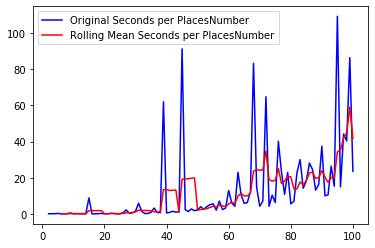

In [12]:
ms_per_places = df.groupby('Places').mean()['VerificationTime']/1000
plt.plot(ms_per_places, color="blue",label="Original Seconds per PlacesNumber") 
rolling_mean = ms_per_places.rolling(5).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Seconds per PlacesNumber") 
plt.legend(loc="best")

#### Number of transitions

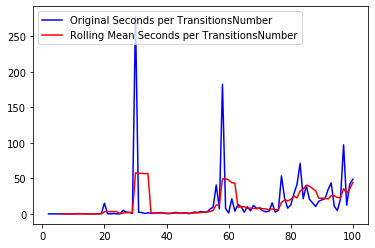

In [13]:
ms_per_transitions = df.groupby('Transitions').mean()['VerificationTime']/1000
plt.plot(ms_per_transitions, color="blue",label="Original Seconds per TransitionsNumber") 
rolling_mean = ms_per_transitions.rolling(5).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Seconds per TransitionsNumber") 
plt.legend(loc="upper left")

#### Number of arcs

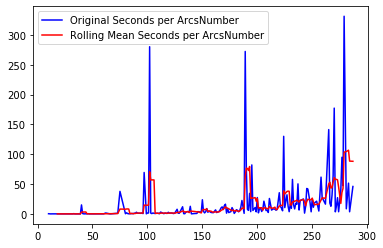

In [14]:
ms_per_arcs = df.groupby('Arcs').mean()['VerificationTime']/1000
plt.plot(ms_per_arcs, color="blue",label="Original Seconds per ArcsNumber") 
rolling_mean = ms_per_arcs.rolling(5).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Seconds per ArcsNumber") 
plt.legend(loc="upper left")

#### Number of variables

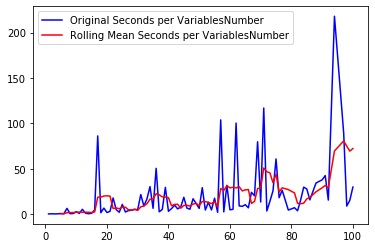

In [15]:
ms_per_vars = df.groupby('Variables').mean()['VerificationTime']/1000
plt.plot(ms_per_vars, color="blue",label="Original Seconds per VariablesNumber") 
rolling_mean = ms_per_vars.rolling(5).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Seconds per VariablesNumber") 
plt.legend(loc="best")

#### Number of conditions

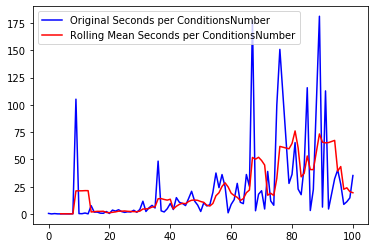

In [16]:
ms_per_conditions = df.groupby('Conditions').mean()['VerificationTime']/1000
plt.plot(ms_per_conditions, color="blue",label="Original Seconds per ConditionsNumber") 
rolling_mean = ms_per_conditions.rolling(5).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Seconds per ConditionsNumber") 
plt.legend(loc="best")

### Model for input parameters
Here we cannot straightforwardly use a linear regression model since milliseconds grow exponentially with the increase of most input parameters. Thus, we can take log from milliseconds and use the linear regression model with the dependent variable log(milliseconds).

(Based on correlation matrix, we can conclude that placesCount and transitionsCount highly correlate with each other; thus, we can choose one of them to represent the size of the model. Let us choose PlacesCount)

In [24]:
df['log_milliseconds'] = df.apply(lambda x: math.log(x['VerificationTime']+1), axis = 1)

In [25]:
x_mult2 = df[['Places', 'Transitions',  'Variables', 'Conditions']]#,'Arcs', 
y2 = df['log_milliseconds']
x_mult_constant2 = sm.add_constant(x_mult2)

In [26]:
model2 = sm.OLS(y2, x_mult_constant2.astype(float)).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:       log_milliseconds   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     357.4
Date:                Wed, 15 Feb 2023   Prob (F-statistic):          8.08e-145
Time:                        17:55:48   Log-Likelihood:                -742.06
No. Observations:                 503   AIC:                             1494.
Df Residuals:                     498   BIC:                             1515.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.2401      0.099     42.932      

In [27]:
coefs = pd.DataFrame()
coefs['Coefs'] = model2.params[1:]
coefs['Coefs'] = (np.exp(coefs['Coefs']) - 1) * 100
coefs['Features'] = model2.params.index[1:]
coefs.set_index('Features', inplace=True)
coefs

,Coefs
Features,
Places,2.263941
Transitions,2.135431
Variables,0.864111
Conditions,2.105594


#### Trying to use linear model against net_size = |Places| * |Transitions|

In [28]:
df['net_size'] = df.Places * df.Transitions

In [29]:
x_mult2 = df[['net_size', 'Arcs', 'Variables', 'Conditions']]
y2 = df['log_milliseconds']
x_mult_constant2 = sm.add_constant(x_mult2)

In [30]:
model2 = sm.OLS(y2, x_mult_constant2.astype(float)).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:       log_milliseconds   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     342.2
Date:                Wed, 15 Feb 2023   Prob (F-statistic):          2.38e-141
Time:                        17:56:12   Log-Likelihood:                -750.14
No. Observations:                 503   AIC:                             1510.
Df Residuals:                     498   BIC:                             1531.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2012      0.140     30.115      0.0

In [31]:
coefs = pd.DataFrame()
coefs['Coefs'] = model2.params[1:]
coefs['Coefs'] = (np.exp(coefs['Coefs']) - 1) * 100
coefs['Features'] = model2.params.index[1:]
coefs.set_index('Features', inplace=True)
coefs

,Coefs
Features,
net_size,0.001568
Arcs,1.515524
Variables,1.059527
Conditions,2.132045


## Protocol 2

### Bounded unsound nets verification

In [2]:
df_base = pd.read_csv('Comparison//BaseVersion.csv')
df_optimized = pd.read_csv('Comparison//OptimizedVersion.csv')

In [3]:
timing_base = df_base.groupby('Transitions').mean()['VerificationTime']
timing_optimized = df_optimized.groupby('Transitions').mean()['VerificationTime']

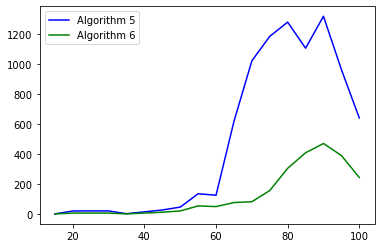

In [5]:
plt.plot(timing_base.rolling(3).mean()/1000 , color="blue", label="Algorithm 5") 
plt.plot(timing_optimized.rolling(3).mean()/1000 , color="green", label="Algorithm 6")
plt.legend(loc="best")

### Sound nets verification

In [7]:
df_base = pd.read_csv('Comparison//Sound//BaseVersion.csv')
df_optimized = pd.read_csv('Comparison//Sound//OptimizedVersion.csv')

In [7]:
timing_base = df_base.groupby('Transitions').mean()['VerificationTime']
timing_optimized = df_optimized.groupby('Transitions').mean()['VerificationTime']

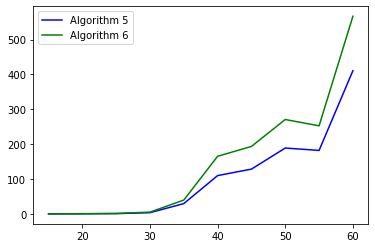

In [8]:
plt.plot(timing_base.rolling(3).mean()/1000 , color="blue", label="Algorithm 5") 
plt.plot(timing_optimized.rolling(3).mean()/1000 , color="green", label="Algorithm 6")
#plt.plot(df/1000, color="blue",linestyle='dashed',  label="Straightforward Version 1") 

plt.legend(loc="best")